Classificando Emoções

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization #dropout zera neuronios e evita overfitting

In [2]:
# Conectando com o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

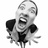

In [4]:
# visualizando imagem aleatoria
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

In [5]:
gerador_treinamento = ImageDataGenerator(rescale=1./255, # normalização das imagens
                                         rotation_range=7, # rotação
                                         horizontal_flip=True,
                                         zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/fer2013/train', # passando o dataset de treino
                                                              target_size = (48, 48), # tamanho das imagens 48x48
                                                              batch_size = 16, # envia de 16 em 16 imagens
                                                              class_mode = 'categorical', # categorical pq o problema de mais de 2 classes
                                                              shuffle = True) # para misturar e evitar que a rede neural decore a ordem das imagens

Found 28709 images belonging to 7 classes.


In [6]:
# observando as classes
dataset_treinamento.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [7]:
# observando todos os valores unicos
np.unique(dataset_treinamento.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [8]:
# observando o nome de cada classe
dataset_treinamento.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

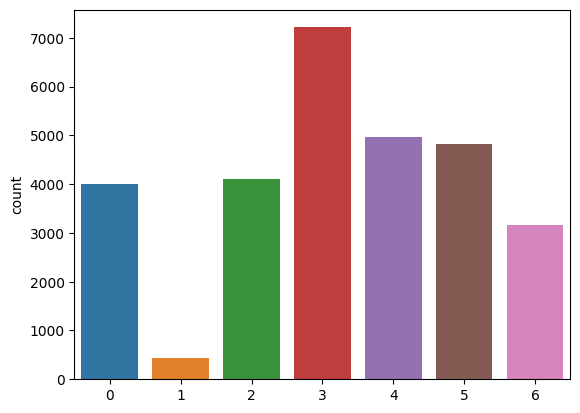

In [9]:
# Gráfico para observar as classes. percebe-se que a base de dados é bem desbalanceada
sns.countplot(x = dataset_treinamento.classes);

In [10]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1, # avalia de 1 em 1
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


In [11]:
# Construindo a rede neural
numero_detectores = 32 # numero de filtros da rede neural
numero_classes = 7 # 6 emoções + neutro
largura, altura = 48, 48
epocas = 70

network = Sequential()

network.add(Conv2D(filters=numero_detectores, kernel_size=(3,3), activation='relu', padding='same', input_shape=(largura, altura, 3))) #kernel 3x3 tamanho da matriz padding(same) preeenchimento de zeros nas bordas para aproveitar todos os pizels da imagem. 3 num de canais
network.add(BatchNormalization()) # normaliza na primeira camada de convolução
network.add(Conv2D(filters=numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) # input_shape só precisa na primeira camada
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2))) # extrai uma parte da imagem para tirar o maior valor (partes principais da imagen)2x2 2 linhas e 2 colunas
network.add(Dropout(0.2)) # para previnir o overfitting. 0.2 zerando 20% dos neuronios

network.add(Conv2D(filters=2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) # multiplica os detectore 2 por 32
network.add(BatchNormalization())
network.add(Conv2D(filters=2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(filters=2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))# multiplica os detectores 2*2*32
network.add(BatchNormalization())
network.add(Conv2D(filters=2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(filters=2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same')) # multiplica os detectores 2*2*2*32
network.add(BatchNormalization())
network.add(Conv2D(filters=2*2*2*numero_detectores, kernel_size=(3,3), activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten()) # transforma matriz em vetor para a parte densa da rede neural

network.add(Dense(units=2 * numero_detectores, activation='relu')) # definindo o numero de neuronios na camada oculta
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(units=2 * numero_detectores, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(units=numero_classes, activation='softmax'))# camada de saída função de ativação softmax pq tem mais de 2 classes
print(network.summary()) # observando o modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                        

In [12]:
# compilando a rede neural
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# iniciando o treinamento
network.fit(dataset_treinamento, epochs=epocas)

Epoch 1/70
1795/1795 [==============================] - 69s 31ms/step - loss: 1.8925 - accuracy: 0.2426
Epoch 2/70
1795/1795 [==============================] - 53s 29ms/step - loss: 1.6094 - accuracy: 0.3609
Epoch 3/70
1795/1795 [==============================] - 55s 31ms/step - loss: 1.4120 - accuracy: 0.4590
Epoch 4/70
1795/1795 [==============================] - 52s 29ms/step - loss: 1.3242 - accuracy: 0.4979
Epoch 5/70
1795/1795 [==============================] - 54s 30ms/step - loss: 1.2746 - accuracy: 0.5191
Epoch 6/70
1795/1795 [==============================] - 52s 29ms/step - loss: 1.2269 - accuracy: 0.5401
Epoch 7/70
1795/1795 [==============================] - 55s 30ms/step - loss: 1.1920 - accuracy: 0.5551
Epoch 8/70
1795/1795 [==============================] - 53s 29ms/step - loss: 1.1623 - accuracy: 0.5693
Epoch 9/70
1795/1795 [==============================] - 55s 30ms/step - loss: 1.1334 - accuracy: 0.5820
Epoch 10/70
1795/1795 [==============================] - 54s 30m

In [21]:
# salvando a rede neural
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [22]:
# salvado os pesos
from keras.models import save_model
network_saved = save_model(network, '/content/weights_emotions.hdf5')

<ipython-input-22-e96973e40e2a>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights_emotions.hdf5')


In [23]:
# carregando a rede neural salva
with open('/content/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 48, 48, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias

In [24]:
# carregando os pesos
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [25]:
# Observando a descrição no resumo
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                        

In [26]:
# enviando a base de teste para avaliar uma por uma e obtendo uma acuracia final
network_loaded.evaluate(dataset_teste)

3589/3589 [==============================] - 18s 5ms/step - loss: 1.5100 - accuracy: 0.5815


[1.5099629163742065, 0.5814990401268005]

In [27]:
previsoes = network_loaded.predict(dataset_teste)
previsoes

3589/3589 [==============================] - 13s 3ms/step


array([[9.04634297e-01, 9.30628926e-03, 4.29703109e-02, ...,
        5.04939677e-03, 2.68164091e-02, 1.08658336e-02],
       [9.71232712e-01, 9.29888847e-05, 2.50253752e-02, ...,
        8.12407816e-04, 1.23875635e-03, 8.52223020e-04],
       [9.68214571e-01, 2.05993143e-04, 8.91439710e-03, ...,
        4.80932370e-03, 1.68506503e-02, 5.87463774e-06],
       ...,
       [7.07353698e-04, 1.34191951e-05, 4.20645662e-02, ...,
        6.54425181e-04, 1.34405727e-03, 9.55003202e-01],
       [7.75965862e-03, 7.75442822e-05, 1.50498629e-01, ...,
        1.64150242e-02, 2.85102753e-03, 8.21697176e-01],
       [3.97450151e-03, 1.37395755e-05, 7.82384723e-03, ...,
        1.83834124e-03, 6.20755658e-04, 9.79012191e-01]], dtype=float32)

In [28]:
# extração dos indices de maior valor
previsoes = np.argmax(previsoes, axis = 1)
previsoes

array([0, 0, 0, ..., 6, 6, 6])

In [29]:
# comparando com as respostas da base de dados acertou as 3 primeira e 3 ultimas 0 e 6
dataset_teste.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [18]:
# observando os indices das previsões
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [30]:
# observando a acuracia através do sklearn
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.5814990247979939

In [31]:
# observando os indices das previsões
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [35]:
# observando a matriz de confusão. Somatório da diagonal principal e dividir pelo numero de registros para atingir acuracia
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
cm

array([[293,   5,  47,  16,  58,  63,   9],
       [  5,  40,   1,   1,   1,   5,   2],
       [ 67,   1, 249,  23,  47,  83,  58],
       [ 20,   2,   5, 775,  39,  19,  19],
       [101,   8,  90, 152, 109, 102,  64],
       [ 58,   2,  59,  38, 130, 298,   9],
       [  9,   1,  47,  21,   4,  11, 323]])

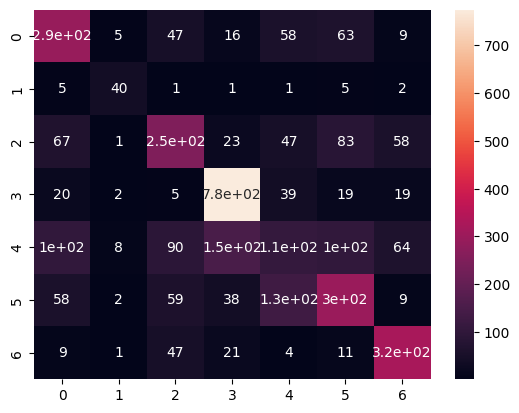

In [33]:
# visualizando a matriz de confusão
sns.heatmap(cm, annot=True);

In [34]:
# observando o classification report onde o algoritmo consegue identificar 88% das faces felizes com precisão de 76%
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.53      0.60      0.56       491
           1       0.68      0.73      0.70        55
           2       0.50      0.47      0.49       528
           3       0.76      0.88      0.81       879
           4       0.28      0.17      0.21       626
           5       0.51      0.50      0.51       594
           6       0.67      0.78      0.72       416

    accuracy                           0.58      3589
   macro avg       0.56      0.59      0.57      3589
weighted avg       0.55      0.58      0.56      3589



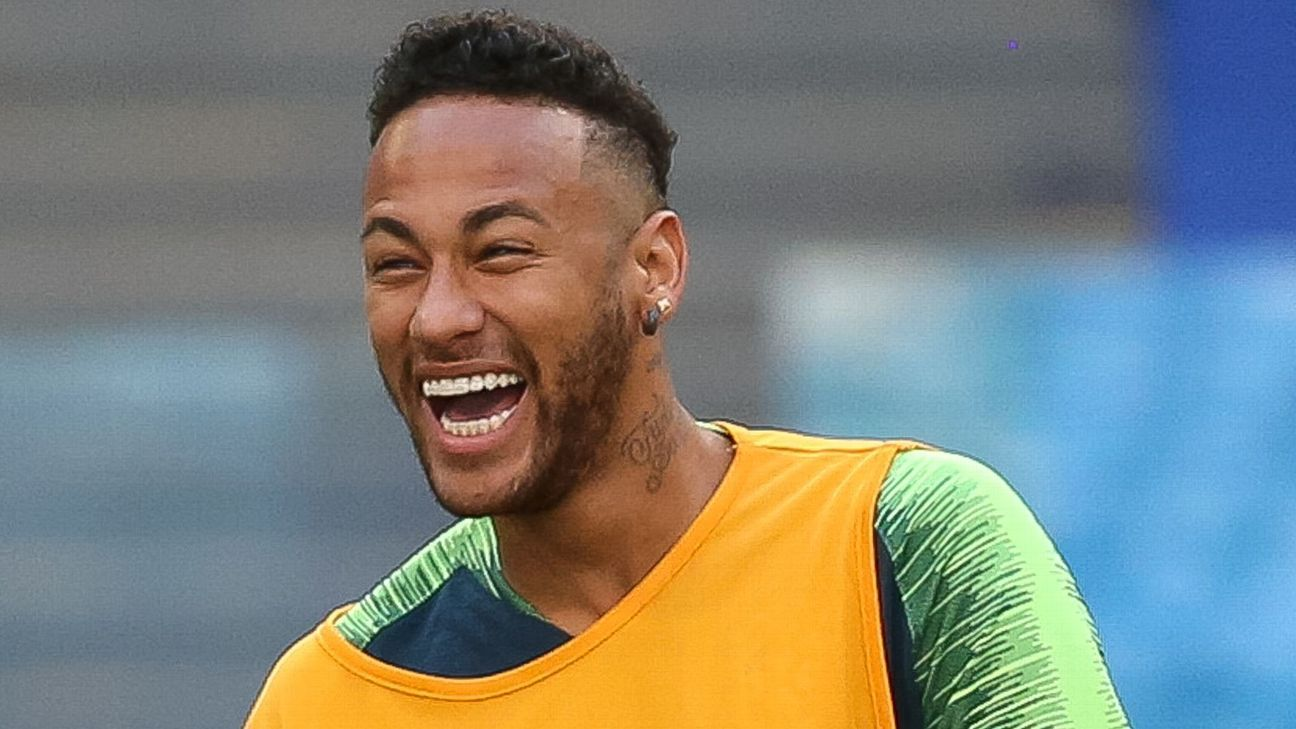

In [19]:
# Carregando uma nova imagem
imagem = cv2.imread('/content/neyamar.jpg')
cv2_imshow(imagem)

In [20]:
imagem.shape

(729, 1296, 3)

In [36]:
# separando apenas a face da imagem
detector_face = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [37]:
# fazendo uma copia da imagem original
imagem_original = imagem.copy()
deteccoes = detector_face.detectMultiScale(imagem_original) # fazendo a detecção

In [38]:
# observando que foi criado um bouding box
deteccoes

array([[269, 114, 361, 361]], dtype=int32)

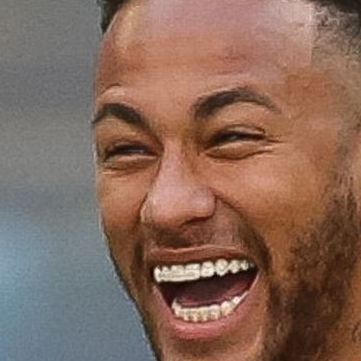

In [40]:
# extraindo a parte da imagem que esta no bouding box atraves da roi região de interesse
roi = imagem[114:114 + 361, 269:269 + 361]# posição 114(posição inicial) até posição 114+361(posição final)
cv2_imshow(roi)

In [41]:
roi.shape

(361, 361, 3)

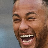

In [42]:
# redimensionando a imagem para 48x48 pq a rede neural foi treinada com esses tamanho de imagem
roi = cv2.resize(roi, (48,48))
cv2_imshow(roi)

In [43]:
# confirmando o redimensionamento
roi.shape

(48, 48, 3)

In [44]:
# visualizando os valores dos pixels
roi

array([[[112, 117, 118],
        [119, 124, 125],
        [111, 116, 117],
        ...,
        [ 27,  33,  41],
        [ 27,  33,  40],
        [ 24,  30,  37]],

       [[115, 120, 121],
        [121, 126, 127],
        [115, 119, 120],
        ...,
        [ 51,  56,  71],
        [ 32,  40,  47],
        [ 32,  38,  46]],

       [[113, 118, 121],
        [116, 121, 124],
        [116, 120, 123],
        ...,
        [ 93, 101, 118],
        [ 52,  60,  73],
        [ 54,  63,  74]],

       ...,

       [[149, 131, 107],
        [150, 135, 113],
        [147, 132, 113],
        ...,
        [ 27,  58, 103],
        [ 40,  70, 116],
        [ 63,  90, 137]],

       [[150, 132, 110],
        [144, 129, 109],
        [143, 129, 110],
        ...,
        [ 45,  78, 124],
        [ 48,  82, 132],
        [ 57,  91, 140]],

       [[145, 127, 104],
        [136, 121,  99],
        [142, 127, 109],
        ...,
        [ 45,  74, 125],
        [ 48,  85, 137],
        [ 54,  91, 150]]

In [45]:
# aplicando a normalização para que fique na escala 0 e 1
roi = roi / 255
roi

array([[[0.43921569, 0.45882353, 0.4627451 ],
        [0.46666667, 0.48627451, 0.49019608],
        [0.43529412, 0.45490196, 0.45882353],
        ...,
        [0.10588235, 0.12941176, 0.16078431],
        [0.10588235, 0.12941176, 0.15686275],
        [0.09411765, 0.11764706, 0.14509804]],

       [[0.45098039, 0.47058824, 0.4745098 ],
        [0.4745098 , 0.49411765, 0.49803922],
        [0.45098039, 0.46666667, 0.47058824],
        ...,
        [0.2       , 0.21960784, 0.27843137],
        [0.1254902 , 0.15686275, 0.18431373],
        [0.1254902 , 0.14901961, 0.18039216]],

       [[0.44313725, 0.4627451 , 0.4745098 ],
        [0.45490196, 0.4745098 , 0.48627451],
        [0.45490196, 0.47058824, 0.48235294],
        ...,
        [0.36470588, 0.39607843, 0.4627451 ],
        [0.20392157, 0.23529412, 0.28627451],
        [0.21176471, 0.24705882, 0.29019608]],

       ...,

       [[0.58431373, 0.51372549, 0.41960784],
        [0.58823529, 0.52941176, 0.44313725],
        [0.57647059, 0

In [46]:
# Adicionando nova dimensão na primeira posição para indicar o bach que é a quantidade de imagens enviadas para a rede neural
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [47]:
# gerando as probabilidades 1 para cada uma das classes
probs = network_loaded.predict(roi)
probs

1/1 [==============================] - 0s 319ms/step


array([[5.4179537e-03, 5.1096149e-06, 1.3354644e-03, 9.9104780e-01,
        1.2418318e-03, 7.3725852e-05, 8.7811257e-04]], dtype=float32)

In [48]:
# criando a variavel previsão com as probabilidades como parâmetro, onde indica o maior valor de probabilidade
previsao = np.argmax(probs)
previsao

3

In [49]:
# classificação final deu 3 happy, que é feliz, ou seja a rede neural acertou
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

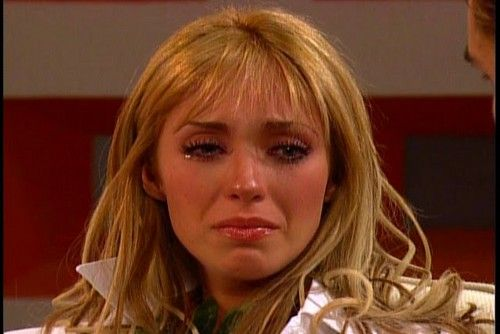

In [51]:
imagem2 = cv2.imread('/content/328c87afd6ec80e5068623871e4c0bdf.jpg')
cv2_imshow(imagem)

In [52]:
imagem2.shape

(334, 500, 3)

In [53]:
detector_face2 = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [54]:
imagem_original2 = imagem2.copy()
deteccoes2 = detector_face2.detectMultiScale(imagem_original2)

In [56]:
deteccoes2

array([[134,  60, 221, 221]], dtype=int32)

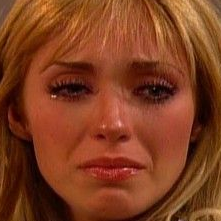

In [58]:
roi2 = imagem2[60:60 + 221, 134:134 + 221]
cv2_imshow(roi2)

In [59]:
roi2.shape

(221, 221, 3)

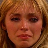

In [61]:
roi2 = cv2.resize(roi2, (48,48))
cv2_imshow(roi2)

In [62]:
roi2.shape

(48, 48, 3)

In [63]:
roi2 = roi2 / 255
roi2

array([[[0.23529412, 0.30196078, 0.42352941],
        [0.23137255, 0.30588235, 0.43529412],
        [0.21176471, 0.31764706, 0.44705882],
        ...,
        [0.28627451, 0.4       , 0.57254902],
        [0.22745098, 0.30196078, 0.43921569],
        [0.2627451 , 0.35686275, 0.4745098 ]],

       [[0.23921569, 0.29019608, 0.42352941],
        [0.23137255, 0.29803922, 0.42352941],
        [0.18823529, 0.30980392, 0.48235294],
        ...,
        [0.25882353, 0.43529412, 0.60784314],
        [0.27843137, 0.39607843, 0.52941176],
        [0.22352941, 0.30588235, 0.41176471]],

       [[0.30588235, 0.34509804, 0.4745098 ],
        [0.21568627, 0.27058824, 0.43921569],
        [0.24313725, 0.44705882, 0.68235294],
        ...,
        [0.30980392, 0.51372549, 0.69803922],
        [0.3254902 , 0.4745098 , 0.62745098],
        [0.31372549, 0.4       , 0.5254902 ]],

       ...,

       [[0.00784314, 0.11372549, 0.29803922],
        [0.00392157, 0.07058824, 0.25490196],
        [0.00784314, 0

In [64]:
roi2 = np.expand_dims(roi2, axis = 0)
roi2.shape

(1, 48, 48, 3)

In [65]:
probs2 = network_loaded.predict(roi2)
probs2

1/1 [==============================] - 0s 45ms/step


array([[0.07536251, 0.00890262, 0.02336771, 0.01929314, 0.01508745,
        0.8563423 , 0.0016442 ]], dtype=float32)

In [66]:
previsao2 = np.argmax(probs2)
previsao2

5

In [67]:
# classificação final deu 5 sad, que é triste, ou seja a rede neural acertou
dataset_teste.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}